In [64]:
# If ipytest isn't installed in your environment, run:
# %pip install -q ipytest pytest
# %pip install matplotlib

## configuration

In [65]:
# "Księga [numer księgi]" lub "Epilog"
CHAPTER_TITLE_REGEX_PL = r'^\s*(?:Księga\s+(\w+)|Epilog)\s*$'

CONFIG = {
    'top_longest_words_number': 10,
    'top_most_common_words_number': 10,
    # text above start_marker and below end_marker will be cleaned up, before analysis
    'start_marker': "Księga pierwsza",
    'end_marker': "-----",
    # I'm not sure if we want ignored workds in histagram, so I made it configurable
    "include_ignored_words_in_histogram": True,
    "minimum_word_length": 4,
    'ignored_words': [
        "lecz", "więc", "przed", "przy"
    ],
    'ignored_regexps': [
        CHAPTER_TITLE_REGEX_PL
    ],
}

#### Technical functions (file loading, handling errors, generating histogram chart etc)

In [66]:
def ensure_string(input_text):
    """Raises TypeError if input_text is not a string."""
    if not isinstance(input_text, str):
        raise TypeError(
            f"expected a string, got {type(input_text).__name__}"
        )


def load_text(filename):
    """Loads text from a file."""
    ensure_string(filename)
    if not filename.endswith(".txt"):
        raise ValueError(f"Expected a .txt file, got {filename!r} instead.")
    file = open(filename, "r", encoding="utf-8")
    text = file.read()
    file.close()

    return text

import matplotlib.pyplot as plt
from collections import Counter

def words_length_histogram(words_list):
    word_lengths = [len(s) for s in words_list]

    length_counter = Counter(word_lengths)

    sorted_lengths = sorted(length_counter.keys())
    counts = [length_counter[length] for length in sorted_lengths]

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(sorted_lengths, counts, color='skyblue', edgecolor='black')

    ax.set_xlabel('Długość słowa', fontsize=14)
    ax.set_ylabel('Częstotliwość', fontsize=14)
    ax.set_title('Histogram Długości Słów', fontsize=16)

    ax.set_xticks(sorted_lengths)

    for length, count in zip(sorted_lengths, counts):
        ax.text(length, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)

    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()



In [67]:
import re

def tokenize_by_regexp(input_text):
    """Tokenizes text using a regular expression to find word boundaries.
    - Converts text to lowercase.
    - Extracts word-like tokens (letters, numbers, underscores, digits).
    - Raises TypeError for non-string inputs.
    """
    ensure_string(input_text)
    return re.findall(r"\b\w+\b", input_text.lower())


In [68]:
def words_by_length(words_list, n=None):
    words = sorted(set(words_list), key=len, reverse=True)
    return words if n is None else words[:n]


In [69]:
def words_by_frequency(words_list, n=None, ignored_words=[], minimum_word_length = 4):
    ignored_set = set(ignored_words)

    filtered_words = [
        word for word in words_list
        if word not in ignored_set and len(word) >= minimum_word_length
    ]
    word_counts = Counter(filtered_words)
    return word_counts.most_common(n)


In [70]:
def cleanup_text(text, config=CONFIG):
    start_index = text.find(config.get('start_marker')) - 1
    end_index = text.find(config.get('end_marker'))
    text = text[start_index:end_index]

    """Removes phrases from text by defined regexps."""
    flags = re.IGNORECASE | re.DOTALL | re.MULTILINE
    for regexp in config.get("ignored_regexps", []):
        text = re.sub(regexp, "", text, flags=flags)

    # in the end we do not clear out the ignored words at this level, as we need them for histogram
    if not config.get("include_ignored_words_in_histogram", False):
        for word in config.get("ignored_words", []):
            regex = r'\b' + re.escape(word) + r'\b'
            text = re.sub(regex, '', text, flags=re.IGNORECASE)
    return text

### Pan Tadeusz - Adam Mickiewicz. Najdłuższe i najczęściej występujęce słowa

In [71]:
def ex01_imp(filename = 'pan-tadeusz.txt'):
    cleaned_text = cleanup_text(load_text(filename))

    all_words = tokenize_by_regexp(cleaned_text)

    print("\nNajdłuższe słowa w Panu Tadeuszu to:\n")
    top_longest_words = words_by_length(all_words, CONFIG['top_longest_words_number'])

    for word in top_longest_words:
        print(f" - {word} długość: {len(word)}")

    print("\nNajczęściej występujące słowa w Panu Tadeuszu to:\n")
    top_most_common_words = words_by_frequency(all_words, CONFIG['top_most_common_words_number'], CONFIG['ignored_words'], CONFIG['minimum_word_length'])

    for word, count in top_most_common_words:
        print(f" - {word}: {count}")
    return all_words

all_words = ex01_imp('pan-tadeusz.txt')



Najdłuższe słowa w Panu Tadeuszu to:

 - niebezpieczeństwach długość: 19
 - białopiotrowiczowi długość: 18
 - najprzykładniejszy długość: 18
 - niebezpieczeństwem długość: 18
 - niebezpieczeństwo długość: 17
 - niebezpieczeństwa długość: 17
 - białopiotrowiczem długość: 17
 - nierozstrzygniony długość: 17
 - najstraszniejsza długość: 16
 - najpiękniejszego długość: 16

Najczęściej występujące słowa w Panu Tadeuszu to:

 - jest: 176
 - rzekł: 155
 - tylko: 149
 - jako: 145
 - mnie: 144
 - hrabia: 129
 - sędzia: 127
 - tadeusz: 106
 - jeszcze: 101
 - przez: 97


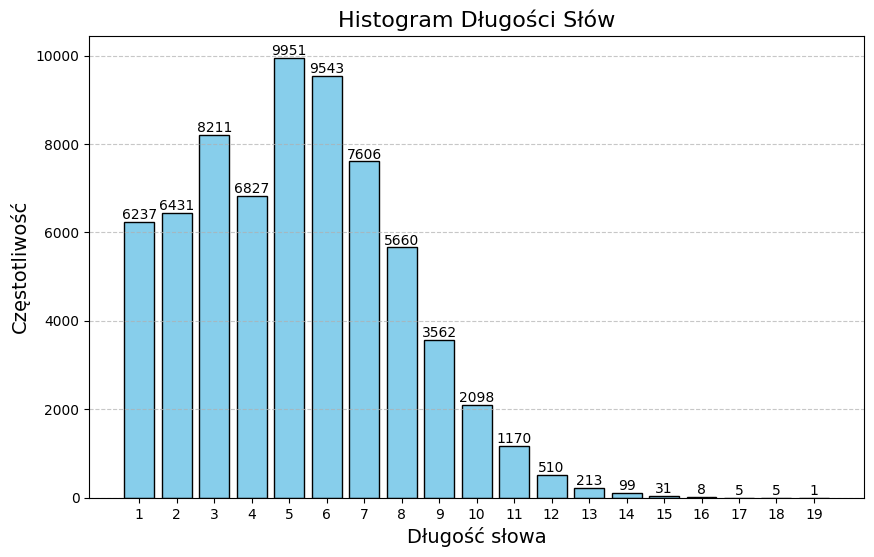

In [72]:
words_length_histogram(all_words)

### Unit Tests

In [73]:
import ipytest
import pytest

ipytest.autoconfig()  # integrate pytest with the notebook

test words_by_length

In [74]:

@pytest.mark.parametrize(
    "text, n, expected",
    [
        ("Ala ma kota", 3, ["kota", "ala", "ma"]),
        ("Ala ma kota", 1, ["kota"]),
        # words should be unique on the list
        ("Ala ma kota, Ala ma Kota", 100, ["kota", "ala", "ma"]),
        ("To be, or not to be, that is the question.", 2, ["question", "that"])
    ],
)
def test_words_by_length(text, n, expected):
    words_list = tokenize_by_regexp(text)
    assert words_by_length(words_list, n) == expected

@pytest.mark.parametrize(
    "text, expected",
    [
        ("Ala ma kota", ["kota", "ala", "ma"]),
        ("Ala ma kota. Kota Ala ma", ['kota', 'ala', 'ma'])
    ],
)
def test_words_by_length_without_results_length(text, expected):
    # without n (representing max results length)
    words_list = tokenize_by_regexp(text)
    assert words_by_length(words_list) == expected

test tokenize_by_regexp

In [75]:
@pytest.mark.parametrize(
    "text, expected",
    [
        ("123 abc", ["123", "abc"]),
        # skipping interpunction
        ("Ala ma kota, kot ma Alę!", ["ala", "ma", "kota", "kot", "ma", "alę"]),
        # other witespace characters
        ("123 abc\n456\tdef", ["123", "abc", "456", "def"]),
        # edge cases
        ("", []),
        ("   \t\n  ", []),
    ],
)
def test_tokenize_by_regexp(text, expected):
    assert tokenize_by_regexp(text) == expected

test most_common_words

In [76]:

@pytest.mark.parametrize(
    "text, n, expected",
    [
        ("world world world", 1, [('world', 3)]),
        ("world world world", 3, [('world', 3)]),
        ("world \nworld \t world. ", 4, [('world', 3)]),
        ("World WORLD, worLD!", 3, [('world', 3)]),
        ("Hello WORLD! Hello World, Hello Jason", 3, [('hello', 3), ('world', 2), ("jason", 1)]),

        ("", 3, []),
        (" \n\t ", 3, []),
    ]
)
def test_words_by_frequency(text, n, expected):
    words_list = tokenize_by_regexp(text)
    assert words_by_frequency(words_list, n) == expected

In [77]:
def test_cleanup():
    text = """Adam Mickiewicz

Pan Tadeusz
czyli ostatni zajazd na Litwie

ISBN 978-83-288-2495-9





Księga pierwsza

Gospodarstwo

Powrót panicza — Spotkanie się pierwsze w pokoiku, drugie u stołu — Ważna Sędziego nauka o grzeczności — Podkomorzego uwagi polityczne nad modami — Początek sporu o Kusego i Sokoła — Żale Wojskiego — Ostatni Woźny Trybunału — Rzut oka na ówczesny stan polityczny Litwy i Europy

    Litwo! Ojczyzno moja! ty jesteś jak zdrowie:
Ile cię trzeba cenić, ten tylko się dowie,
Kto cię stracił. Dziś piękność twą w całej ozdobie

Księga dwunasta

Kochajmy się

Ostatnia uczta staropolska — Arcy-serwis — Objaśnienie jego figur — Jego ruchy — Dąbrowski udarowany — Jeszcze o Scyzoryku — Kniaziewicz udarowany — Pierwszy akt urzędowy Tadeusza przy objęciu dziedzictwa — Uwagi Gerwazego — Koncert nad koncertami — Polonez — Kochajmy się.

    Na koniec z trzaskiem sali drzwi na wściąż otwarto.
Wchodzi pan Wojski

Epilog

    O tymże dumać na paryskim bruku,
Przynosząc z miasta uszy pełne stuku,
Przeklęstw i kłamstwa, niewczesnych zamiarów,
Zapóźnych żalów, potępieńczych swarów?


-----
Ta lektura, podobnie jak tysiące innych, dostępna jest na stronie wolnelektury.pl.
Wersja lektury w opracowaniu merytorycznym i krytycznym (przypisy i motywy) dostępna jest na stronie http://wolnelektury.pl/katalog/lektura/pan-tadeusz.

Utwór opracowany został w ramach projektu Wolne Lektury przez fundację Wolne Lektury.

Wszystkie zasoby Wolnych Lektur możesz swobodnie wykorzystywać, publikować i rozpowszechniać pod warunkiem zachowania warunków licencji i zgodnie z Zasadami wykorzystania Wolnych Lektur.
Ten utwór jest w domenie publicznej.
Wszystkie materiały dodatkowe (przypisy, motywy literackie) są udostępnione na Licencji Wolnej Sztuki 1.3: https://artlibre.org/licence/lal/pl/
Fundacja Wolne Lektury zastrzega sobie prawa do wydania krytycznego zgodnie z art. Art.99(2) Ustawy o prawach autorskich i prawach pokrewnych.
Wykorzystując zasoby z Wolnych Lektur, należy pamiętać o zapisach licencji oraz zasadach, które spisaliśmy w Zasadach wykorzystania Wolnych Lektur: https://wolnelektury.pl/info/zasady-wykorzystania/
Zapoznaj się z nimi, zanim udostępnisz dalej nasze książki.

Tekst opracowany na podstawie: Adam Mickiewicz, Pisma Adama Mickiewicza, Wydanie zupełne, Tom V, Paryż 1860

Wydawca: Fundacja Nowoczesna Polska

Publikacja zrealizowana w ramach projektu Wolne Lektury (http://wolnelektury.pl). Reprodukcja cyfrowa wykonana przez Bibliotekę Narodową z egzemplarza pochodzącego ze zbiorów BN.

Opracowanie redakcyjne i przypisy: Maria Bailey, Anna Dyja, Marta Niedziałkowska, Agnieszka Paul, Magdalena Paul, Aleksandra Sekuła, Weronika Trzeciak.

ISBN-978-83-288-2495-9
"""
    print(text)
    config = CONFIG
    cleaned_text = cleanup_text(text, config)

    # "Księga pierwsza" title extracted as a title
    assert "Księga pierwsza" not in cleaned_text
    # subtitle of Księga pierwsza
    assert "Gospodarstwo" in cleaned_text
    # fragment of "księga pierwsza" content
    assert "Powrót panicza" in cleaned_text

    # title excluded
    assert "Księga dwunasta" not in cleaned_text

    # "Epilog" not included as a title
    assert "Epilog" not in cleaned_text
    # Epilog's text fragment included as a title
    assert "    O tymże dumać na paryskim bruku," in cleaned_text

    assert "Ta lektura, podobnie jak tysiące innych," not in cleaned_text
    print(cleaned_text)


In [78]:
ipytest.run()

...................                                                                          [100%]
19 passed in 0.02s


<ExitCode.OK: 0>